In [2]:
import pandas as pd
import numpy as np
import geopandas
%matplotlib inline

# Introduction

We are trying to find the best neighborhood to raise children by looking at the neighborhoods with the most recreational facilities by area, the number crimmes in the area, and enrollment of students in the area. 

# Metric 1: Parks

I created a dataframe, calculating the parks per acre for each neighborhood. I first combined all of the datasets, then I masked the area and created a dataframe from that. Afterward, I did math using two lists to create new list with parks per acre, then making it into one set. 

In [5]:
# read the csvs and counted them after grouping
rec = pd.read_csv("City of Pittsburgh Playing Fields.csv", index_col = "id")
numrec = rec.groupby('neighborhood').count()
playground = pd.read_csv("Playgrounds.csv")
play = playground.groupby('neighborhood').count()

# combined two datasets
recreation = pd.concat([numrec, play])
court = pd.read_csv("Courts and Rinks.csv")
court = court.groupby('neighborhood').count()

#combined the third data set with the first 2
recreation = pd.concat([recreation, court])['park']
recreation = pd.DataFrame(recreation)
recreation = recreation.groupby('neighborhood').sum()
#sorted by number of parks instead of alphabetically
rec = recreation.sort_values(by=['park'], ascending=False)
rec

,park
neighborhood,
Squirrel Hill South,39
Highland Park,28
Hazelwood,17
South Side Slopes,17
Brookline,17
...,...
Homewood South,1
Homewood North,1
West Oakland,1


In [7]:
# read another csv and then masked it
area = pd.read_csv("Neighborhood Size.csv")
mask = area['acres'] > 0
area = area[mask]
area = area.groupby('hood').sum()['acres']
newarea = pd.DataFrame(area) #created new dataframe

#reset to easier merge
recreation = recreation.reset_index()
newarea = newarea.reset_index()
reca = newarea.merge(recreation, left_on="hood", right_on ="neighborhood")
reca.drop(labels = 'neighborhood', axis = 1) #dropped uneeded label
recbyarea = reca['park'] / reca['acres'] #division needed for parks per acre
recbyarea = pd.DataFrame(recbyarea, columns = ["parks per acre"])
reca = reca.merge(recbyarea, left_index=True, right_index=True) #combine list with dataset
reca = reca.sort_values(by = ['parks per acre'], ascending=False) #sort by values instead of alphabetically
reca

,hood,acres,index,neighborhood,park,parks per acre
0,Allegheny Center,134.703,0,Allegheny Center,15,0.111356
50,Regent Square,123.682,51,Regent Square,9,0.072767
6,Beltzhoover,270.374,6,Beltzhoover,16,0.059177
39,Manchester,179.566,39,Manchester,10,0.055690
64,Troy Hill,247.170,65,Troy Hill,13,0.052595
...,...,...,...,...,...,...
32,Homewood North,279.140,32,Homewood North,1,0.003582
2,Arlington,302.320,2,Arlington,1,0.003308
47,Point Breeze,645.695,48,Point Breeze,2,0.003097
29,Hays,1125.478,29,Hays,2,0.001777


Made a chloropleth map to visualize the recreaional facilities per acre for each neighborhood. 

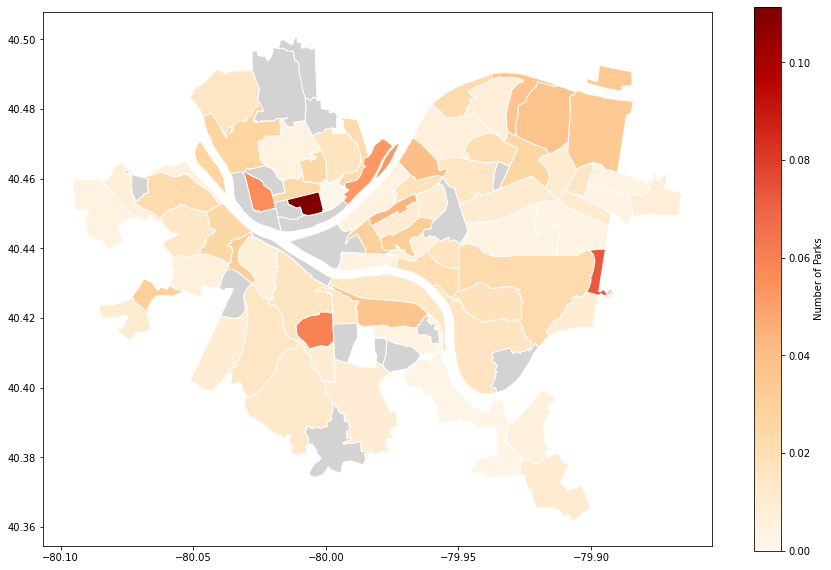

In [8]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp") # read in the shapefile
# created a map
rec_map = neighborhoods.merge(reca, how='left', left_on='hood', right_on='hood')
rec_map.plot(column='parks per acre', # set the data to be used for coloring
               cmap='OrRd',              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Number of Parks"}, # label the legend
               figsize=(15, 10),         # set the size
               missing_kwds={"color": "lightgrey"} # set disctricts with no data to gray
               )

# Conclusion 1
Compiling all the data, we found that Squirrel Hill South has the most recreational facilities out of all of the neighborhood. But this is an inaccurate measurement so I also combined an area dataset to the previous dataset. Then I calculated recreational facilities per acre and ranked them from there, finding that Allegheny Center has the most recreational facilities per acre. 
My favorite neighborhood is Squirrel Hill South so I found that it has the most recreational facilities but not the most per acre.

I made an algorithm that goes down the list making a rank for each one, where the best one gets 1 and so on.

In [6]:
parkranks = {}
counter = 0
prev = -1
same = 1
for index,row in reca.iterrows():
    if row['parks per acre'] == prev: #takes account of duplicates
        same = same + 1
    else:
        counter = counter + same #after no more duplicate values
        same = 1
    parkranks[row['hood']]= counter # creates the rank
    prev = row['parks per acre']
parkranks = parkranks.items()
column = ["neighborhood","parkrank"]
parkranks = pd.DataFrame(parkranks, columns=column) #creates the dataframe
parkranks

,neighborhood,parkrank
0,Allegheny Center,1
1,Regent Square,2
2,Beltzhoover,3
3,Manchester,4
4,Troy Hill,5
...,...,...
66,Homewood North,67
67,Arlington,68
68,Point Breeze,69
69,Hays,70


# Metric 2: Crime

This is the number of arrests recorded from highest to lowest in each neighborhood in Pittsburgh.The top five neighborhoods with the highest arrest rates are "South Side Flats", "Central Business District", "East Allegheny", "Carrick" and "East Liberty". The top five neighborhoods with the lowest arrest rates are "Mt. Oliver Neighborhood", "Swisshelm", "New Homestead", "Ridgemont" and "Chartiers City".

In [9]:
Arrest = pd.read_csv("Arrest in Pittsburgh.csv")
arrest = Arrest.groupby('INCIDENTNEIGHBORHOOD').count().sort_values(by=['OFFENSES'], ascending=True)
arrest

,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
INCIDENTNEIGHBORHOOD,,,,,,,,,,,,,,,
Mt. Oliver Neighborhood,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
New Homestead,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
Swisshelm Park,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
Ridgemont,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
Chartiers City,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
East Liberty,197,197,189,197,197,197,197,197,197,197,197,194,194,197,197
Carrick,248,248,245,248,248,248,248,248,248,248,248,241,241,248,248
East Allegheny,293,293,291,293,293,293,293,293,293,293,293,293,293,293,293


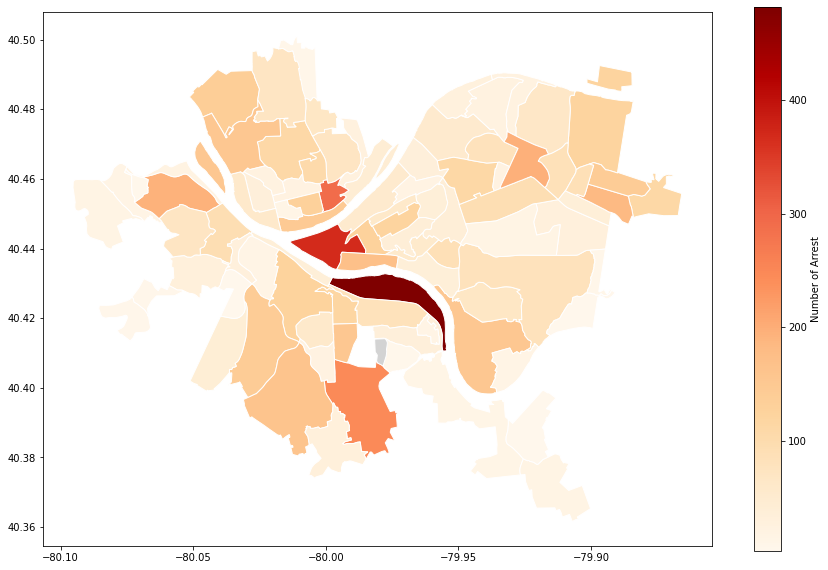

In [11]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp") 
arrest_map = neighborhoods.merge(arrest, how='left', left_on='hood', right_on='INCIDENTNEIGHBORHOOD')
arrest_map.plot(column='OFFENSES', 
               cmap='OrRd',             
               edgecolor="white",        
               legend=True,              
               legend_kwds={'label': "Number of Arrest"}, 
               figsize=(15, 10),        
               missing_kwds={"color": "lightgrey"} 
               )

Finally, I use a map of Pittsburgh to better illustrate the security situation in each neighborhood.The darker the color, the higher the crime rate. Conversely, lighter colors indicate lower crime rates in neighborhoods. Hence, you can see clearly on the map that there are some high crime neighborhoods on the north and south sides of Pittsburgh. And also, neighborhoods to the east and west of Pittsburgh are relatively safe.

# Conclusion 2:

Through the data, the top five neighborhoods with the highest arrest rates in Pittsburgh are "South Side Flats", "Central Business District", "East Allegheny", "Carrick" and "East Liberty". The top five neighborhoods in Pittsburgh with the lowest arrest rates are "Mt. Oliver Neighborhood", "Swisshelm", "New Homestead", "Ridgemont" and "Chartiers City". 

I hadn't heard of these five communities, though they had the lowest crime rates. I think it's possible that these communities have a lower population that leads to less crime. So my data is one-dimensional, and it doesn't show you how good a neighborhood is, it just tells you how safe it is. 

I live on shadyside now, and the security of this neighborhood is not bad. There are also many large supermarkets here. Such as Target and Whole Foods. Hence, I think shadyside is the best neighborhood for me. However, the best neighborhood I found is Mt. Oliver Neighborhood with the lowest arrest rate. it may be the best in terms of policing, but in many ways it's not necessarily the best. 

Same algorithm used for the parks metric, taking into account of duplicates

In [16]:
crimeranks = {}
counter = 0
prev = -1
same = 1
for index,row in arrest.iterrows():
    if row['OFFENSES'] == prev: #takes account of duplicates
        same = same + 1
    else:
        counter = counter + same #after no more duplicate values
        same = 1
    crimeranks[index]= counter # creates the rank
    prev = row['OFFENSES']
crimeranks = crimeranks.items()
column = ["neighborhood","crimerank"]
crimeranks = pd.DataFrame(crimeranks, columns=column) #creates the dataframe
crimeranks

,neighborhood,crimerank
0,Mt. Oliver Neighborhood,1
1,New Homestead,2
2,Swisshelm Park,2
3,Ridgemont,4
4,Chartiers City,5
...,...,...
92,East Liberty,93
93,Carrick,94
94,East Allegheny,95
95,Central Business District,96


# Metric 3: Education

In [13]:
Enrollment = pd.read_csv("Enrollment by Neighborhood 2020-21 school yr.csv")
# Forming intened datasheet
# In the row datasheet, the enrollment number was recorded in each quarter.
#By adding all enrollment numebr in 4 quarters together, I get total enrollment by year.
# Then I make the ranking list of total enrollment by year.  
Total_Enrollment_Year = Enrollment.groupby('neighborhood').sum()
tey = Total_Enrollment_Year.sort_values(by=["total_students_enrolled"],ascending=False)
tey = pd.DataFrame(tey)
tey

,african_american,american_indian,asian__not_pacific_islander,hispanic,multiracial,native_hawaiian_or_other_pacific_islander,white,total_students_enrolled,attending_feeder,attending_nonfeeder,total_with_feeder_status
neighborhood,,,,,,,,,,,
Carrick,362.0,0.0,157.0,37.0,156.0,0.0,546.0,1276.0,803.0,409.0,1212.0
Brookline,153.0,0.0,33.0,63.0,131.0,0.0,758.0,1169.0,715.0,397.0,1112.0
Beechview,187.0,0.0,0.0,177.0,81.0,0.0,326.0,794.0,482.0,268.0,750.0
Sheraden,490.0,0.0,0.0,0.0,89.0,0.0,75.0,694.0,418.0,218.0,636.0
Squirrel Hill South,40.0,0.0,77.0,14.0,61.0,0.0,446.0,679.0,510.0,140.0,650.0
...,...,...,...,...,...,...,...,...,...,...,...
North Oakland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
South Shore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ridgemont,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


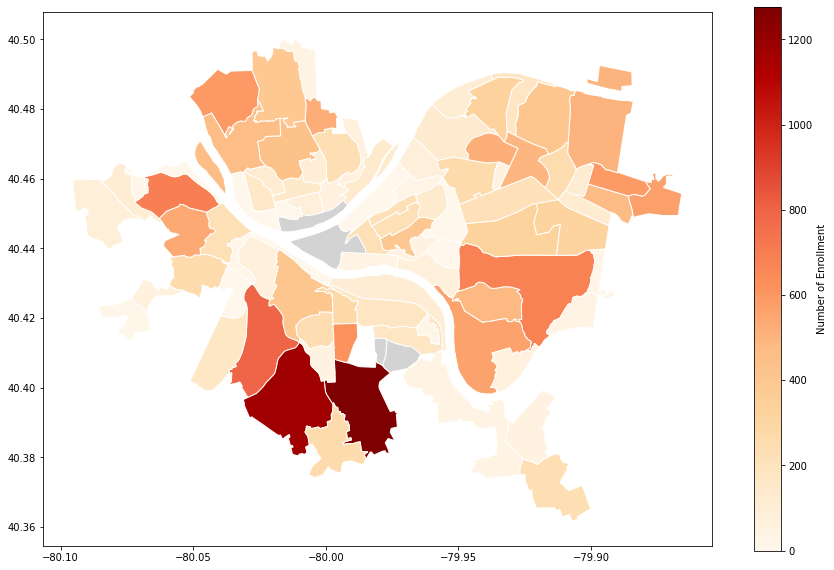

In [14]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp") # read in the shapefile
# read in the shapefile
Total_Enrollment_Year = Enrollment.groupby('neighborhood').sum()

# plot the geopandas dataframe
Total_Enrollment_Year.sort_values("total_students_enrolled", ascending=False, inplace=True)
Enrollment_map = neighborhoods.merge(Total_Enrollment_Year, how='left', left_on='hood', right_on='neighborhood')
#Combination of the enrollment data and the map
#Thses white areas and grey indicate that few enrolled students in these white area.

#These red areas indicate that compared with white areas,there are-
#more enrolled students in these red areas

Enrollment_map.plot(column='total_students_enrolled', # set the data to be used for coloring
               cmap='OrRd',              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Number of Enrollment"}, # label the legend
               figsize=(15, 10),         # set the size
               missing_kwds={"color": "lightgrey"} # set disctricts with no data to gray
                   )

## In Conclusion, after the analysis, Carrick is the best neigborhood who can provid best education cricumstance to children. According to the dataset from 2020-2021, there were 22041 enrolled students from all neighborhoods. Carrick had 1276, which occupy 5.8% of total enrollment in all of neighborhoods.(Showing in the pie chart)

## Furthermore, according to the above map, the south part of the map have more red areas than other parts, which indicates that south part have more enrolled students in public school. 

## Although Carrick is the best neigborhood who can provid best education cricumstance to children, my personal favourite neighbourhood is Squirrel hill, where there are many great restaurants and delicious foods. The Squirrel Hill also is in 5th place in my raking list of enrollment. 

Same ranking system used in the previous 2 metrics.

In [18]:
edranks = {}
counter = 0
prev = -1
same = 1
for index,row in tey.iterrows():
    if row['total_students_enrolled'] == prev: #takes account of duplicates
        same = same + 1
    else:
        counter = counter + same #after no more duplicate values
        same = 1
    edranks[index]= counter # creates the rank
    prev = row['total_students_enrolled'] 
edranks = edranks.items()
column = ["neighborhood","edrank"]
edranks = pd.DataFrame(edranks, columns=column) #creates the dataframe
edranks

,neighborhood,edrank
0,Carrick,1
1,Brookline,2
2,Beechview,3
3,Sheraden,4
4,Squirrel Hill South,5
...,...,...
86,North Oakland,83
87,South Shore,83
88,Ridgemont,83
89,Golden Triangle,83


We combined the three rankings together into one dataframe. 

In [19]:
ranking = crimeranks.merge(edranks)
ranking = ranking.merge(parkranks)
ranking.set_index('neighborhood')

,crimerank,edrank,parkrank
neighborhood,,,
New Homestead,2,68,60
Swisshelm Park,2,75,49
East Carnegie,9,82,43
Oakwood,9,67,14
Regent Square,11,77,2
...,...,...,...
Sheraden,92,4,22
East Liberty,93,15,17
Carrick,94,1,51


After I found the average of the rankings, I sorted by ascending because when each dataset is ranked, the best has the rank 1 and so on. That means when we do the average and want the best, we want the least value average to show which one is the best. 

In [21]:
#found average of the three rankings
avgrank = (ranking['crimerank'] + ranking['edrank'] + ranking['parkrank']) / 3
avgrank = pd.DataFrame(avgrank, columns=['avg'])

#combine with the previous data frame
avgrank = ranking.merge(avgrank, left_index=True, right_index=True)

#sort by least
avg = avgrank.sort_values(by=['avg'],ascending=True)
avg

,neighborhood,crimerank,edrank,parkrank,avg
28,Terrace Village,45,23,12,26.666667
16,Morningside,29,43,10,27.333333
36,Highland Park,56,21,8,28.333333
22,Manchester,38,46,4,29.333333
34,Beltzhoover,53,34,3,30.000000
...,...,...,...,...,...
44,Central Oakland,67,83,31,60.333333
70,South Side Flats,97,56,38,63.666667
31,Strip District,50,83,62,65.000000
64,Bluff,90,73,64,75.666667


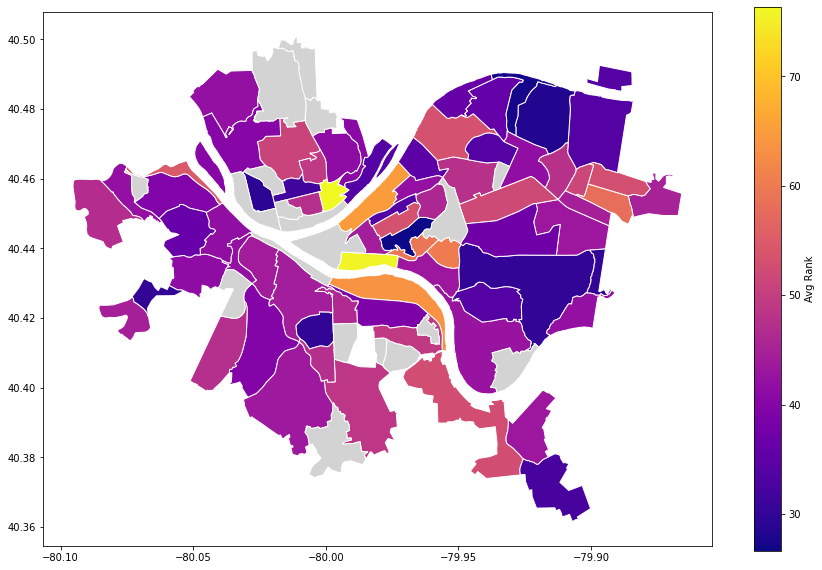

In [28]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
rec_map = neighborhoods.merge(avg, how='left', left_on='hood', right_on='neighborhood')
rec_map.plot(column='avg', # set the data to be used for coloring
               cmap='plasma',              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Avg Rank"}, # label the legend
               figsize=(15, 10),         # set the size
               missing_kwds={"color": "lightgrey"} # set disctricts with no data to gray
               )

We as a group concluded that Terrace Village is the best neighborhood out of all the neighborhoods after being measured by the number of recreational facilities, amount of crime, and education. Following Terrace Village is Morningside, Highland Park, Manchester, and Beltzhoover.
Yurui and I's favorite neighborhood, Squirrel Hill, and Jing's favorite neighborhood of Shadyside are both not in the top 5 of the overall ranking. But Squirrel Hill South is in the top 5 of the ranking for education. 